In [2]:
import os
import csv
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
from queries import Simbad
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from matplotlib.ticker import MultipleLocator

% matplotlib inline

def get_ang_sep(ra1,dec1,ra2,dec2):
    ra1_rad=ra1*np.pi/180.
    dec1_rad=dec1*np.pi/180.
    ra2_rad=ra2*np.pi/180.
    dec2_rad=dec2*np.pi/180.

    del_ra=ra2_rad-ra1_rad
    del_ras=np.sin(del_ra)
    del_rac=np.cos(del_ra)
    dec1s=np.sin(dec1_rad)
    dec2s=np.sin(dec2_rad)
    dec1c=np.cos(dec1_rad)
    dec2c=np.cos(dec2_rad)
    arctan_arg=np.sqrt((dec2c**2)*(del_ras**2)+(dec1c*dec2s-dec1s*dec2c*del_rac)**2)/(dec1s*dec2s+dec1c*dec2c*del_rac)
    if arctan_arg < 0:
        arctan_arg = -arctan_arg
    return (180./np.pi)*np.arctan(arctan_arg)

x1d_dir='/Users/codydirks/PGCC/x1d_files/'
gaia_dir='/Users/codydirks/PGCC/tgas_data/'

In [3]:
#sightlines=[x for x in os.listdir(x1d_dir) if os.path.isdir(x1d_dir+x) and x.startswith('.')==False]
with open('primary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    sightlines=inp.next()
    
gaia_files=[x for x in os.listdir(gaia_dir) if x.endswith('.fits')]
gaia_files.sort()
len(sightlines)

22

In [4]:
pgcc_data=fits.open('/Users/codydirks/PGCC/HFI_PCCS_GCC_R2.02.fits')[1].data

In [5]:
pgcc_results=[]
for sightline in sightlines:
    nearest_pgcc=[]
    nearest=999
    ra,dec=Simbad.Position(sightline)
    galcoords=SkyCoord(ra=ra,dec=dec,frame='icrs').galactic
    glon=galcoords.l.value
    glat=galcoords.b.value
    for pgcc in pgcc_data:
        if abs(pgcc['glon']-glon)<1 and abs(pgcc['glat']-glat)<1:
            angsep=get_ang_sep(pgcc['ra'],pgcc['dec'],ra.value,dec.value)
            if angsep<nearest:
                nearest=angsep
                nearest_pgcc=pgcc
    pgcc_results.append([[sightline,ra,dec],nearest_pgcc])

In [6]:
# Searches for Gaia data on each sightline

gaia_results=[]
for result in pgcc_results:
    sightline=result[0][0]
    print sightline,
    #Find Hipparcos or Tycho identifiers to match to Gaia entries
    idlist=Simbad.IDList(sightline)
    tyc=[x for x in idlist if x.startswith('TYC')]
    hip=[x for x in idlist if x.startswith('HIP')]
    hip_id=-1
    tyc_id=''
    if len(tyc)>0 or len(hip)>0:
        if len(hip)>0:
            hip_id=int(hip[0].split()[1])
        if len(tyc)>0:            
            tyc_id=tyc[0][4:]
        print hip_id,tyc_id,
        for filename in gaia_files:
            #print filenames.index(filename),
            hdulist=fits.open(gaia_dir+filename)
            scidata=hdulist[1].data
            gaia_dat=scidata[scidata['hip']==hip_id]
            if len(gaia_dat)==0:
                gaia_dat=scidata[scidata['tycho2_id']==tyc_id]
            if len(gaia_dat)>0:
                gaia_results.append([result[0],result[1],gaia_dat])
                print 'Found',
                break
    print

HD13841 10624 3694-2597-1 Found
HD23180 17448 
HD23478 17631 2360-780-1 Found
HD24398 18246 2361-2820-1
HD24534 18350 2357-2042-1 Found
HD25443 19139 4068-1167-1 Found
HD43582 -1 1878-51-1 Found
HD62542 37565 7653-2654-1 Found
HD72350 41737 7674-3267-1 Found
HD108927 61193 9416-251-1 Found
HD112999 63565 8989-68-1 Found
HD124314 69628  Found
HD147683 80405 7352-1162-1
HD148594 80819 6803-2097-1
HD148937 81100 8329-3343-1 Found
HD165918 -1 6272-1894-1
HD185418 96608 1606-1996-1 Found
HD203532 106474 9524-2074-1 Found
HD208947 108364 4274-2377-1
HD210839 109556 3981-1585-1
HD232522 8235 3675-2539-1 Found
HD254755 29968 1878-61-1


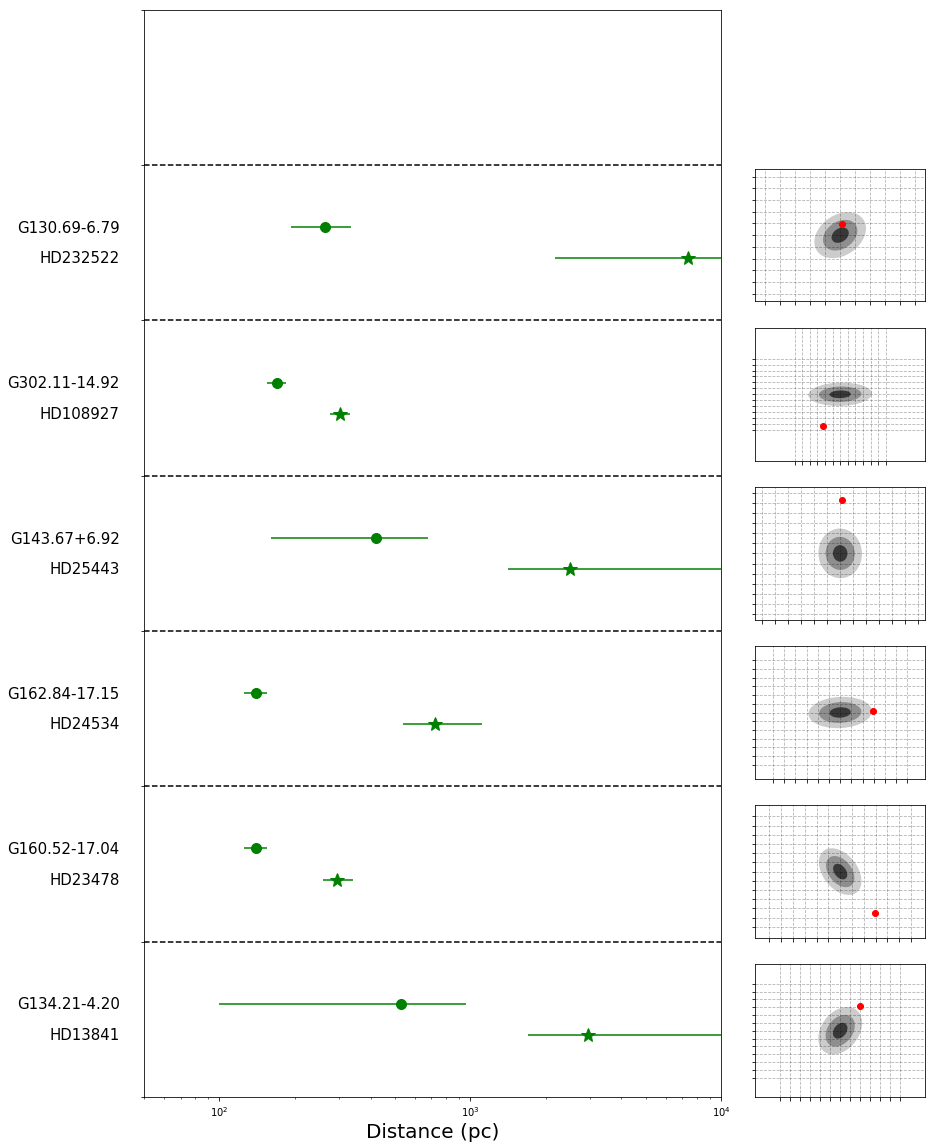

In [7]:
results=[x for x in gaia_results if x[1]['dist']>0.0 and x[1]['gau_major_axis']>0.]
#results=[x for x in results if 1000./(x[2]['parallax']+x[2]['parallax_error'])>1000.*x[1]['dist']+1000.*x[1]['dist_sig']]
#results=[x for x in results if 1000./(x[2]['parallax']>1000.*x[1]['dist'])]

fig=plt.figure(1,figsize=(14,20))
majorLocator=MultipleLocator(5)

G=gridspec.GridSpec(len(results),4)
subplt=plt.subplot(G[:,0:3])
subplt.set_yticklabels([])
subplt.set_ylim(0,len(results))
subplt.set_xlim(50,10000)
subplt.set_xlabel('Distance (pc)',fontsize=20)
subplt.set_xscale('log')
k=0
for result in results:
    sightline=result[0]
    pgcc=result[1]
    gaia_dat=result[2]
    pgcc_dist=1000.*pgcc['dist']
    pgcc_min_dist=pgcc_dist-1000.*pgcc['dist_sig']
    pgcc_max_dist=pgcc_dist+1000.*pgcc['dist_sig']
    
    plx=gaia_dat['parallax']
    plx_err=gaia_dat['parallax_error']
    star_dist=1000./plx
    star_min_dist=1000./(plx+plx_err)
    star_max_dist=1000./(plx-plx_err)
    if star_max_dist<0:
        star_max_dist=2.*star_dist
    
    if star_min_dist>pgcc_max_dist:
        col='g'
    #elif star_max_dist < pgcc_min_dist:
    #    col='r'
    #else:
    #    col='k'
        subplt.errorbar(star_dist,k+0.4,xerr=[[star_dist-star_min_dist],[star_max_dist-star_dist]],fmt='*',color=col,ms=15)
        subplt.errorbar(pgcc_dist,k+0.6,xerr=[[pgcc_dist-pgcc_min_dist],[pgcc_max_dist-pgcc_dist]],fmt='o',color=col,ms=10)
        subplt.text(40,k+0.55,pgcc['name'].split()[1],ha='right',va='bottom',fontsize=15)
        subplt.text(40,k+0.45,sightline[0],ha='right',va='top',fontsize=15)

        subplt.axhline(k+1,0,1,linestyle='--',color='k')


        subplt1=plt.subplot(G[len(results)-k-1,3])
        k=k+1

        subplt1.set_xlim(-4*pgcc['gau_major_axis'],4*pgcc['gau_major_axis'])
        subplt1.set_ylim(-4*pgcc['gau_major_axis'],4*pgcc['gau_major_axis'])
        subplt1.set_xticklabels([])
        subplt1.set_yticklabels([])
        subplt1.xaxis.set_major_locator(majorLocator)
        subplt1.yaxis.set_major_locator(majorLocator)
        subplt1.grid(linestyle='--',color='k',alpha=0.3)
        for i in range(1,4):
            ell=Ellipse(xy=(0,0),width=i*pgcc['gau_major_axis'],
                        height=i*pgcc['gau_minor_axis'],angle=-(180./np.pi)*pgcc['gau_position_angle'])
            ell.set_facecolor('k')
            ell.set_alpha(0.6/i)
            subplt1.add_patch(ell)

        gal=SkyCoord(ra=sightline[1],dec=sightline[2],frame='icrs').galactic
        del_l=60.*(gal.l.value-pgcc['glon'])
        del_b=60.*(gal.b.value-pgcc['glat'])
        #if (((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2)<=1.:
        subplt1.plot(del_l,del_b,'ro')


In [20]:
for result in pgcc_results:
    dist=
    print '{:>8}'.format(round(Simbad.Distance(result[0][0]).value,2)),
    print 1000*result[1]['dist']

 2941.18 529.99997139
  343.64 140.000000596
  294.12 140.000000596
  230.41 0.0
  724.64 140.000000596
  2500.0 419.999986887
 1449.28 0.0
   366.3 0.0
  606.06 1090.00003338
  302.11 170.000001788
  653.59 0.0
  3125.0 0.0
   393.7 0.0
  173.01 119.999997318
 2083.33 8569.99969482


SimbadError: No distance found for `HD165918`